In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.mean()
avg_temp.drop(index=[30.0, 150.0, 210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.drop(columns=["2.0", "3.5", "5.0", "6.5"], inplace=True)
avg_temp.head(13)

,1.25,2.75,4.25,5.75,7.25
0.0,1.360195,1.906685,3.331275,5.096230,5.192810
60.0,2.101070,2.798130,3.340425,3.614315,4.392805
90.0,1.531960,1.866900,2.318210,2.346175,2.505455
120.0,1.898960,3.038300,3.002945,2.791730,2.513745
180.0,1.661300,2.747570,2.688655,2.270890,1.916750


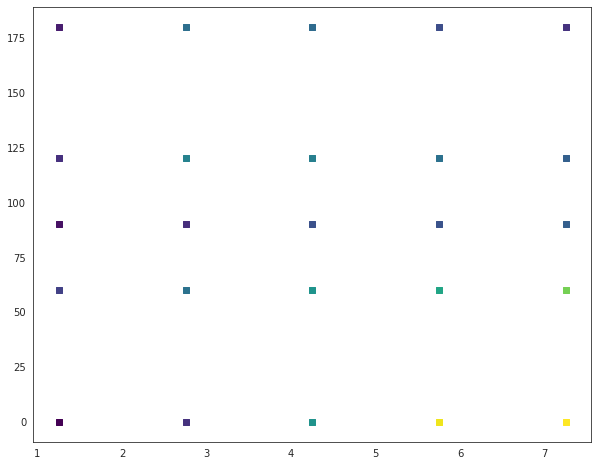

In [4]:
nx1 = 30
nx2 = 1
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])
y_obs_norm = [float(i)/sum(y_obs) for i in y_obs]

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis);

In [5]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [6]:
RANDOM_SEED = 42
CHAINS = 4

In [7]:
with pm.Model() as polynomial_regression:
    X1 = np.asarray(x11)
    X2 = np.asarray(x22)
    
    y_obs_pm = pm.Data('y_obs_pm', y_obs)
    
    #B0 = pm.Normal('B0',0,10)
    #B1 = pm.Normal('B1',0,10)
    #B2 = pm.Normal('B2',0,10)
    #B11 = pm.Normal('B11',0,10)
    #B22 = pm.Normal('B22',0,10)
    #B12 = pm.Normal('B12',0,10)
    
    beta = pm.Normal('beta',0,10, shape=6)
    sigma = pm.HalfNormal('sigma',100)
    
    mu = beta[0] + beta[1]*X1 + beta[2]*X2 + beta[3]*X1**2 + beta[4]*X2**2 + beta[5]*X1*X2
    y_hat = pm.Normal('y_hat', mu, sigma, observed=y_obs)

In [8]:
with polynomial_regression:
    regression_trace = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 63 seconds.


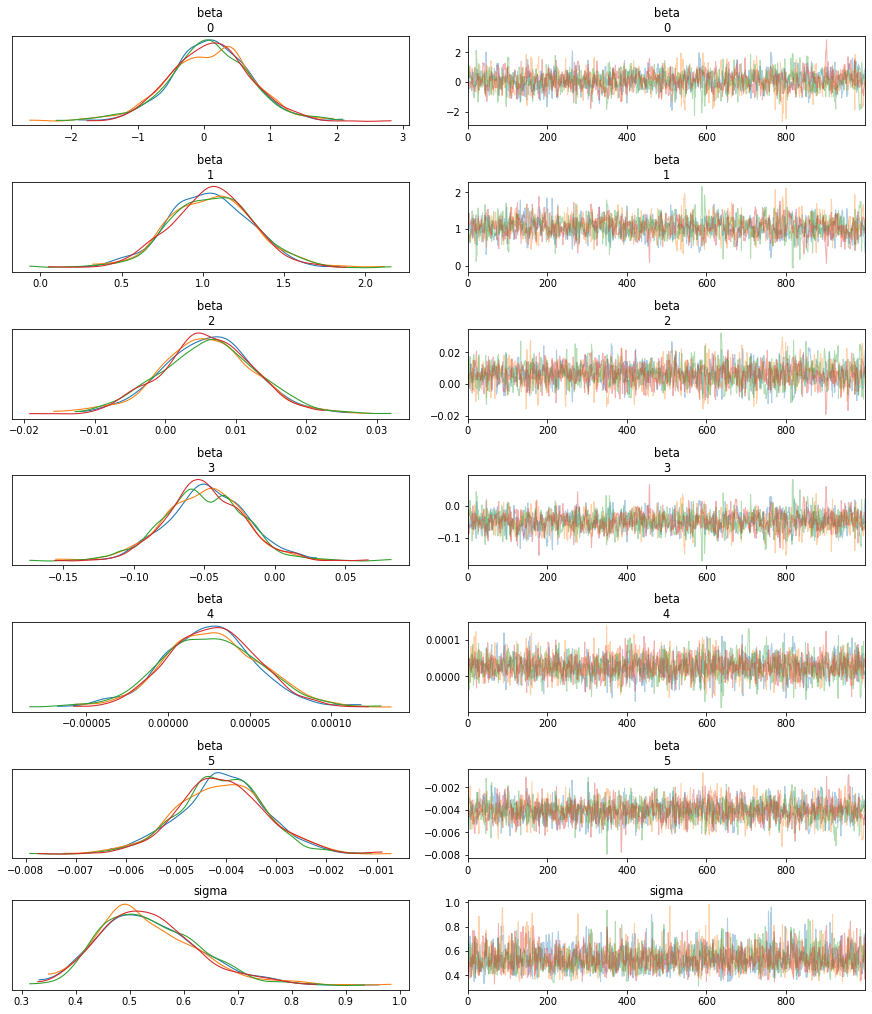

In [9]:
az.plot_trace(regression_trace, compact=False);

array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'beta\n3'}>,
        <AxesSubplot:title={'center':'beta\n4'}>,
        <AxesSubplot:title={'center':'beta\n5'}>],
       [<AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

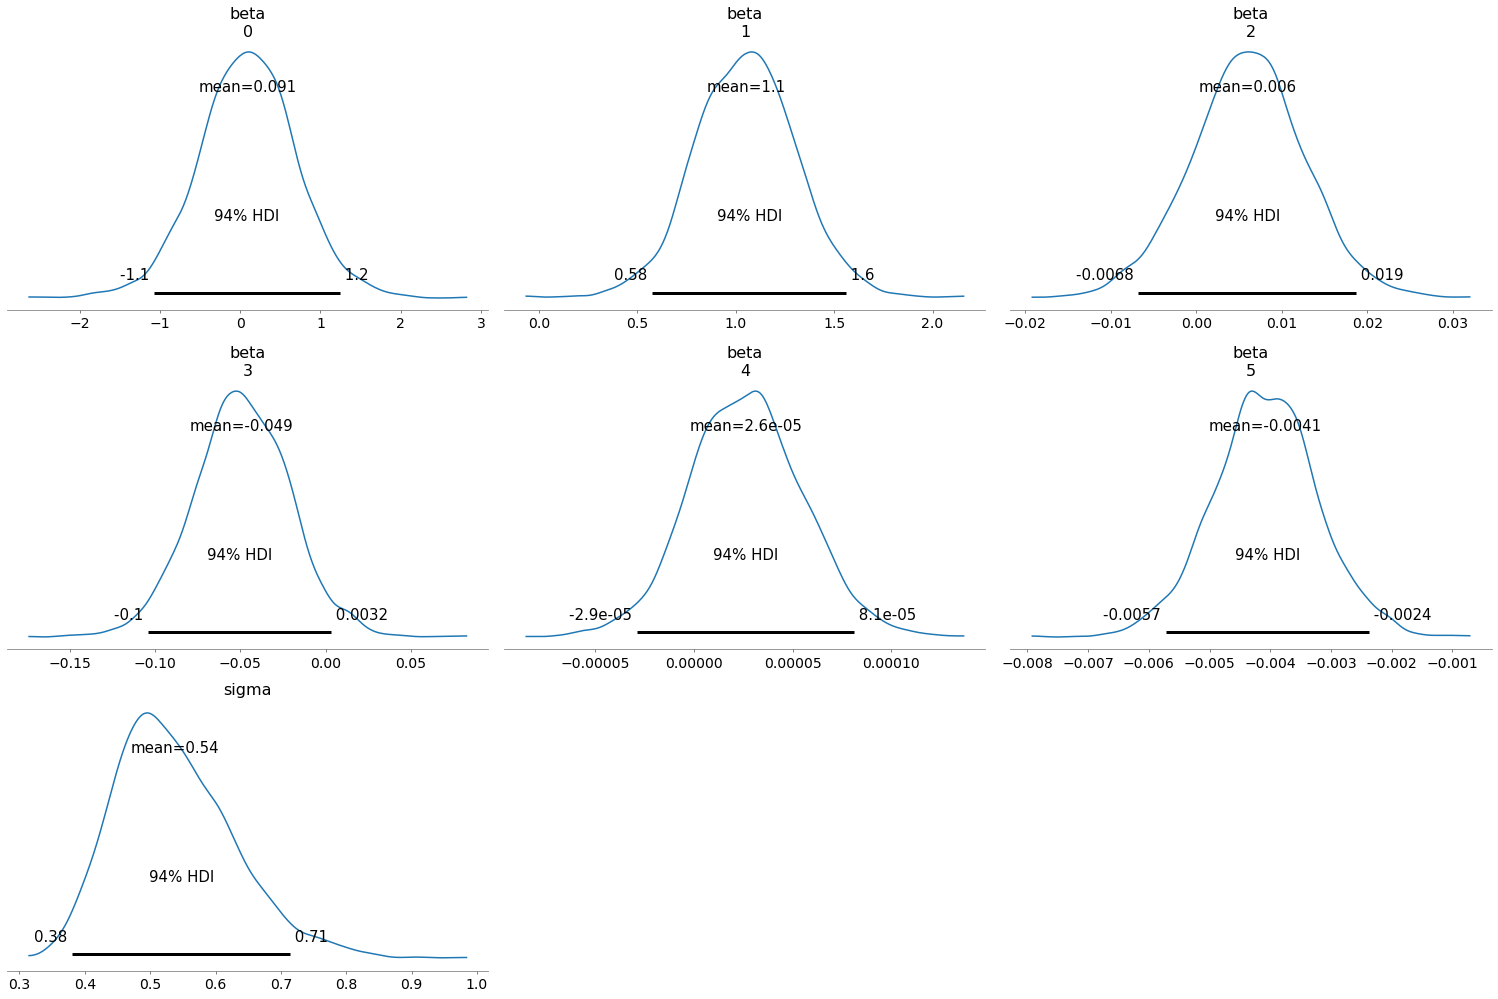

In [10]:
az.plot_posterior(regression_trace)

In [11]:
az.summary(regression_trace, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.091,0.614,-1.067,1.238,0.017,0.012,1280.866,1783.101,1.006
beta[1],1.051,0.261,0.577,1.561,0.007,0.005,1307.023,1751.290,1.003
beta[2],0.006,0.007,-0.007,0.019,0.000,0.000,1597.073,1750.344,1.004
beta[3],-0.049,0.029,-0.104,0.003,0.001,0.001,1389.632,1942.963,1.003
beta[4],0.000,0.000,-0.000,0.000,0.000,0.000,2117.078,2202.883,1.004
beta[5],-0.004,0.001,-0.006,-0.002,0.000,0.000,1753.061,2146.074,1.002
sigma,0.538,0.093,0.381,0.715,0.002,0.001,2086.143,2212.705,1.001


In [12]:
loo_1 = az.loo(regression_trace, polynomial_regression)
loo_1.loo

-22.8019106523709

In [13]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [14]:
n_samples = 4000

samples = []
for b0, b1, b2, b3, b4, b5 in regression_trace['beta'][:n_samples]:
    for d in wd:
        for s in ws:
            samples.append(b0 + b1*s + b2*d + b3*s**2 + b4*d**2 + b5*s*d)
            
samples_1 = np.array(samples)
samples_1 = samples_1.reshape(n_samples,nv*nd)
samples_1

array([[-0.11549338,  0.61739549,  1.2922933 , ...,  0.63538528,
         0.10152387, -0.4903286 ],
       [-0.08739371,  0.61802796,  1.27007937, ...,  0.11849867,
        -0.42408974, -1.0200484 ],
       [ 1.44143043,  1.77283166,  2.09616347, ...,  1.97826729,
         1.89430117,  1.80226564],
       ...,
       [ 0.46100291,  0.91352583,  1.35388913, ...,  1.61567161,
         1.45485175,  1.28187228],
       [ 0.50245322,  0.99202027,  1.45819633, ...,  1.10510883,
         0.84548292,  0.56246603],
       [ 0.64352326,  1.15434686,  1.64167365, ...,  1.08967066,
         0.82114045,  0.52911343]])

In [15]:
s_1 = samples_1.mean(axis=0).reshape(nd,nv)
sd_1 = samples_1.std(axis=0).reshape(nd,nv)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

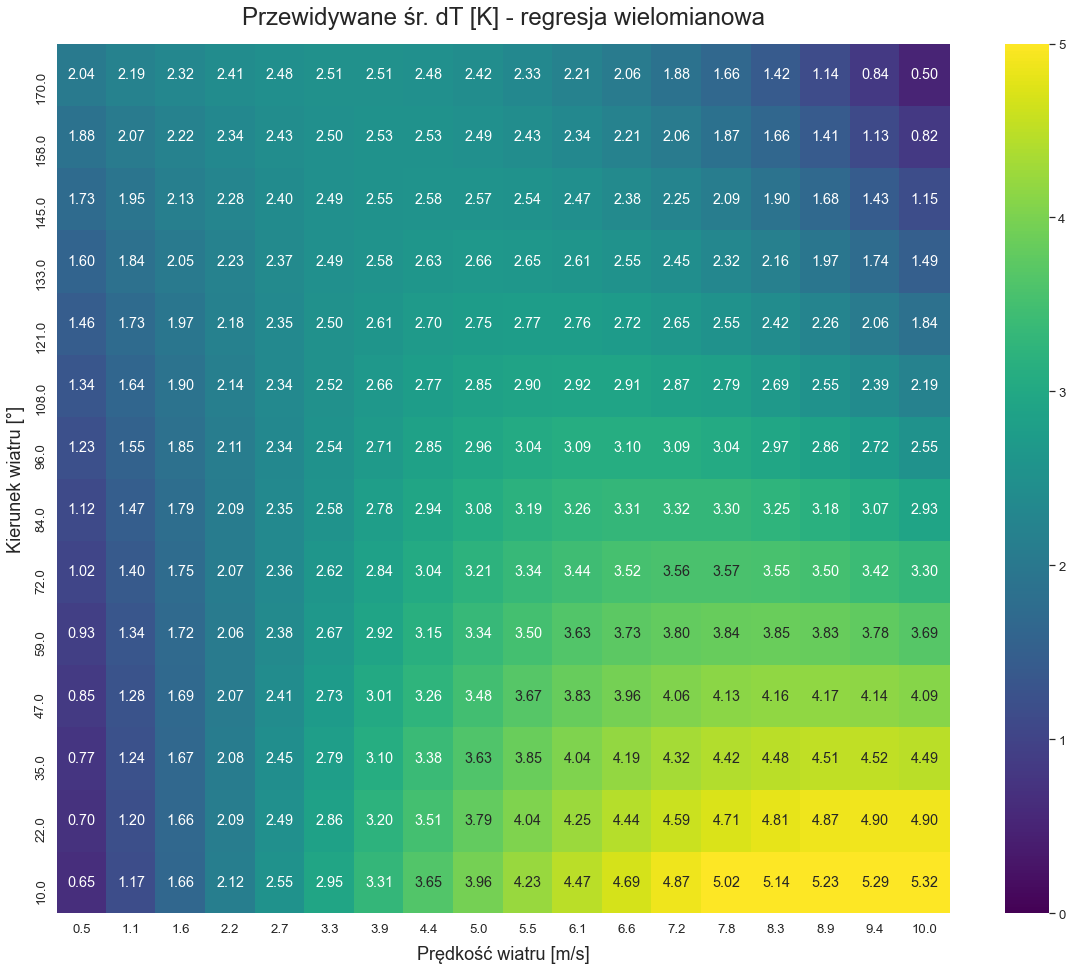

In [16]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_1, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

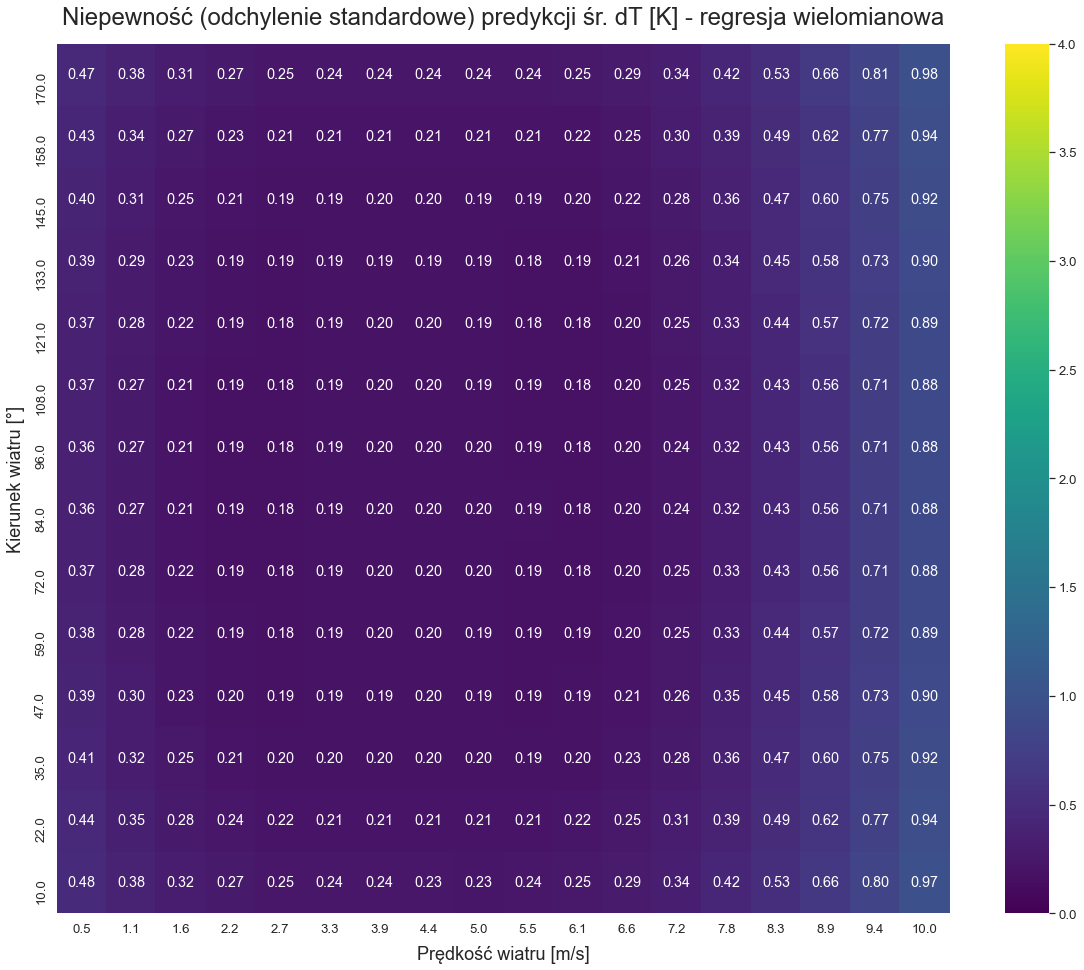

In [17]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_1, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)